<a href="https://colab.research.google.com/github/movAH02h/Network_traffic_analysis_methods/blob/main/Parsing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy

Корневая директория должна быть 'content'

In [ ]:
import logging
import sys


root_logger = logging.getLogger()
root_logger.handlers = []

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)

formatter = logging.Formatter(
    '%(levelname)s: %(message)s',
    datefmt='%H:%M:%S'
)
handler.setFormatter(formatter)

root_logger.setLevel(logging.DEBUG)
root_logger.addHandler(handler)

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

In [ ]:
import io
import logging
import os
import re
from abc import ABC, abstractmethod
from typing import Any, List, Optional, Tuple, Union

import numpy as np
import pandas as pd


class ProcessingStep(ABC):
    """
    Базовый абстрактный класс для звеньев цепочки обработки данных.

    Реализует паттерн "Цепочка обязанностей" (Chain of Responsibility), позволяя
    последовательно применять различные этапы обработки к данным.

    Атрибуты:
        _next_step (ProcessingStep): Ссылка на следующий обработчик в цепочке.
    """

    def __init__(self) -> None:
        """Инициализирует обработчик без следующего звена."""
        self._next_step: Optional['ProcessingStep'] = None

    def set_next(self, step: 'ProcessingStep') -> 'ProcessingStep':
        """
        Устанавливает следующий обработчик в цепочке.

        Аргументы:
            step (ProcessingStep): Следующий обработчик в цепочке.

        Вернёт:
            ProcessingStep: Установленный обработчик для цепочного вызова.
        """
        self._next_step = step
        return step

    @abstractmethod
    def process(self, data: Any) -> Any:
        """
        Обрабатывает данные и передает их следующему звену цепочки.

        Аргументы:
            data: Входные данные для обработки.

        Вернёт:
            Результат обработки последним звеном цепочки или исходные данные.
        """
        if self._next_step:
            return self._next_step.process(data)
        return data


class FileLoader(ProcessingStep):
    """Загружает CSV-файл из указанного пути."""

    def process(self, file_path: str) -> pd.DataFrame:
        """
        Читает CSV-файл в сыром виде и преобразует в DataFrame.

        Аргументы:
            file_path (str): Путь к CSV-файлу для загрузки.

        Вернёт:
            pd.DataFrame: Загруженные данные в виде DataFrame.

        Исключения:
            FileNotFoundError: Если файл не существует.
            UnicodeDecodeError: Если возникают проблемы с декодированием.
            ValueError: При пустом файле или ошибке парсинга.
        """
        logger.info(f"Загрузка: {file_path}")
        try:
            with open(file_path, 'rb') as f:
                raw_content: bytes = f.read()
        except FileNotFoundError:
            logger.error(f"Файл не найден: {file_path}")
            raise FileNotFoundError(f"Файл не найден: {file_path}")
        except PermissionError:
            logger.error(f"Нет прав на чтение файла: {file_path}")
            raise PermissionError(f"Нет прав на чтение файла: {file_path}")
        except OSError as e:
            logger.error(f"Ошибка при чтении файла {file_path}: {e}")
            raise OSError(f"Ошибка при чтении файла {file_path}: {e}")

        try:
            content: str = raw_content.decode('cp1251', errors='ignore')
        except UnicodeDecodeError as e:
            logger.error(f"Ошибка декодирования файла {file_path}: {e}")
            raise UnicodeDecodeError(f"Ошибка декодирования {file_path}: {e}")

        try:
            df: pd.DataFrame = pd.read_csv(
                io.StringIO(content),
                on_bad_lines='skip',
                engine='python',
                index_col=0
            )
        except pd.errors.EmptyDataError:
            logger.error(f"Файл {file_path} пуст или не содержит данных")
            raise ValueError(f"Файл {file_path} пуст или не содержит данных")
        except pd.errors.ParserError as e:
            logger.error(f"Ошибка парсинга CSV файла {file_path}: {e}")
            raise ValueError(f"Ошибка парсинга CSV файла {file_path}: {e}")

        bad_col = 'РС‰РµС‚ СЂР°Р±РѕС‚Сѓ РЅР° РґРѕР»Р¶РЅРѕСЃС‚СЊ:'
        df.rename(
            columns={bad_col: 'Ищет работу на должность'},
            inplace=True
        )
        return super().process(df)


class MojibakeCorrector(ProcessingStep):
    """Исправляет проблемы с кодировкой (Mojibake) в текстовых данных."""

    @staticmethod
    def _repair_string(text: Any) -> Any:
        """
        Исправляет строку с проблемами двойной кодировки.

        Аргументы:
            text (Any): Исходная строка.

        Вернёт:
            Any: Исправленная строка или исходное значение.
        """
        if not isinstance(text, str):
            return text
        try:
            return text.encode('cp1251').decode('utf-8')
        except (UnicodeEncodeError, UnicodeDecodeError):
            return text

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Применяет исправление кодировки ко всему DataFrame.

        Аргументы:
            df (pd.DataFrame): DataFrame с проблемами кодировки.

        Вернёт:
            pd.DataFrame: Исправленный DataFrame.
        """
        logger.info("Исправление кодировки (Mojibake)...")
        df.columns = [self._repair_string(col) for col in df.columns]
        df = df.map(self._repair_string)
        return super().process(df)


class SalaryExtractor(ProcessingStep):
    """Извлекает и преобразует данные о зарплате в числовой формат."""

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Создает целевую переменную 'target_salary' из столбца зарплаты.

        Аргументы:
            df (pd.DataFrame): Исходный DataFrame.

        Вернёт:
            pd.DataFrame: DataFrame с числовой колонкой 'target_salary'.
        """
        logger.info("Извлечение целевой переменной (ЗП)...")

        target_col: Optional[str] = self._find_target_column(df.columns)

        if target_col:
            raw_val = df[target_col].astype(str).str.replace(
                r'[^\d]', '', regex=True
            )
            df['target_salary'] = pd.to_numeric(
                raw_val, errors='coerce'
            ).fillna(0).astype(float)
            df = df.drop(columns=[target_col])
        else:
            logger.warning("Столбец ЗП не найден, установлено 0.0")
            df['target_salary'] = 0.0

        return super().process(df)

    def _find_target_column(self, columns: pd.Index) -> Optional[str]:
        """Находит столбец с зарплатой по названию."""
        for col in columns:
            if 'ЗП' in col.upper():
                return col
        return None


class FeatureEncoder(ProcessingStep):
    """Преобразует категориальные признаки в числовые."""

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Кодирует категориальные столбцы через factorize.

        Аргументы:
            df (pd.DataFrame): DataFrame с категориями.

        Вернёт:
            pd.DataFrame: DataFrame с закодированными признаками.
        """
        logger.info("Кодирование признаков...")
        for col in df.columns:
            if col != 'target_salary' and df[col].dtype == 'object':
                df[col] = pd.factorize(df[col])[0]
        return super().process(df)


class NumpyNanny(ProcessingStep):
    """Сохраняет обработанные данные в формате NumPy."""

    def __init__(self, base_dir: str) -> None:
        """
        Аргументы:
            base_dir (str): Директория для сохранения файлов.
        """
        super().__init__()
        self.output_dir: str = base_dir

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Сохраняет x_data.npy и y_data.npy в указанную директорию.

        Аргументы:
            df (pd.DataFrame): Итоговый DataFrame.

        Вернёт:
            pd.DataFrame: Исходный DataFrame.

        Исключения:
            PermissionError: Если нет прав на запись.
            KeyError: Если отсутствует целевая переменная.
        """
        logger.info("- Сохранение в .npy...")
        try:
            y: np.ndarray = df['target_salary'].values
            x: np.ndarray = df.drop(columns=['target_salary']).values

            if not os.path.exists(self.output_dir):
                os.makedirs(self.output_dir)
                logger.debug(f"Создана директория: {self.output_dir}")

            x_path: str = os.path.join(self.output_dir, 'x_data.npy')
            y_path: str = os.path.join(self.output_dir, 'y_data.npy')

            np.save(x_path, x)
            np.save(y_path, y)
            logger.info(f"Успех. Директория: {self.output_dir}")

            return df

        except KeyError as e:
            logger.error(f"Отсутствует столбец в DataFrame: {e}")
            raise KeyError(f"Отсутствует столбец в DataFrame: {e}")
        except Exception as e:
            logger.error(f"Ошибка сохранения: {e}")
            raise e


def run_app(csv_path: str, base_dir: str) -> None:
    """
    Запускает полный пайплайн обработки данных из CSV-файла.

    Аргументы:
        csv_path (str): Путь к исходному CSV-файлу.
        base_dir (str): Путь для сохранения результатов.
    """
    logger.info(f"Запуск пайплайна для файла: {csv_path}")
    pipeline: FileLoader = FileLoader()

    (pipeline.set_next(MojibakeCorrector())
             .set_next(SalaryExtractor())
             .set_next(FeatureEncoder())
             .set_next(NumpyNanny(base_dir)))

    try:
        pipeline.process(csv_path)
        logger.info("Пайплайн успешно завершен")
    except (FileNotFoundError, ValueError, PermissionError, OSError) as e:
        logger.error(f"Ошибка в пайплайне: {e}")
        raise
    except Exception as e:
        logger.exception(f"Непредвиденная ошибка: {e}")
        raise RuntimeError(f"Непредвиденная ошибка: {e}")

INFO: NumExpr defaulting to 2 threads.


In [ ]:
x_data_file = "x_data.npy"
y_data_file = "y_data.npy"

In [ ]:
def get_user_file_path() -> Optional[Tuple[str, str]]:
    """
    Запрашивает путь к директории у пользователя и формирует путь к файлу.

    Аргументы:
        Нет.

    Вернёт:
        Optional[Tuple[str, str]]: Кортеж (путь_к_файлу, базовая_директория)
            в случае успеха, иначе None.

    Исключения:
        Ошибки ввода-вывода при обращении к файловой системе.
    """
    prompt_msg = (
        f"Введите директорию с файлом 'hh.csv'. "
        f"Туда сохранятся файлы {x_data_file} и {y_data_file}: "
    )

    base_dir: str = input(prompt_msg)
    path_csv: str = os.path.join(base_dir, "hh.csv")

    if not os.path.exists(path_csv):
        logger.error(f"Файл '{path_csv}' не найден")
        return None

    return path_csv, base_dir


result = get_user_file_path()
if result:
    path_csv, base_dir = result
    run_app(path_csv, base_dir)

Введите директорию с файлом 'hh.csv'. Туда сохранятся файлы x_data.npy и y_data.npy: sample_data
INFO: Запуск пайплайна для файла: sample_data/hh.csv
INFO: Загрузка: sample_data/hh.csv
INFO: Исправление кодировки (Mojibake)...
INFO: Извлечение целевой переменной (ЗП)...
INFO: Кодирование признаков...
INFO: - Сохранение в .npy...
INFO: Успех. Директория: sample_data
INFO: Пайплайн успешно завершен


In [ ]:
import numpy as np
import pandas as pd
from typing import Tuple


def display_npy_data(x_data: np.ndarray, y_data: np.ndarray) -> None:
    """
    Загружает и отображает данные из файлов x_data.npy и y_data.npy.

    Вернёт:
        None
    """
    try:
        logger.info(f"Форма X: {x_data.shape}")
        logger.info(f"Форма Y: {y_data.shape}\n\n")

        logger.info("Первые 5 строк признаков:")
        display(pd.DataFrame(x_data).head())

        logger.info("Первые 5 значений целевой переменной:")
        logger.info(f"{y_data[:5]}\n\n")

        logger.info("Статистика:")
        logger.info(f"Минимальная ЗП: {y_data.min():.2f}")
        logger.info(f"Максимальная ЗП: {y_data.max():.2f}")
        logger.info(f"Средняя ЗП: {y_data.mean():.2f}")
        logger.info(f"Медиана ЗП: {np.median(y_data):.2f}\n\n")

        logger.info(f"Общее количество записей: {len(y_data)}")
        logger.info(f"Количество признаков: {x_data.shape[1]}\n\n")

    except FileNotFoundError as e:
        logger.error(f"Файл не найден: {e.filename}")
    except Exception as e:
        logger.error(f"Ошибка при загрузке данных: {e}")


try:
    x_data_path = os.path.join(base_dir, x_data_file)
    x_data: np.ndarray = np.load(x_data_path, allow_pickle=True)
except FileNotFoundError as e:
    logger.error(f"Файл не найден: {e.filename}")

try:
    y_data_path = os.path.join(base_dir, y_data_file)
    y_data: np.ndarray = np.load(y_data_path, allow_pickle=True)
except FileNotFoundError as e:
    logger.error(f"Файл не найден: {e.filename}")

display_npy_data(x_data, y_data)

INFO: Форма X: (66945, 11)
INFO: Форма Y: (66945,)


INFO: Первые 5 строк признаков:


,0,1,2,3,4,5,6,7,8,9,10
0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,1
2,2,2,2,0,2,2,2,2,2,2,1
3,3,3,3,0,3,3,3,3,3,3,1
4,4,4,4,1,4,4,4,4,4,4,1


INFO: Первые 5 значений целевой переменной:
INFO: [27000. 60000. 65000. 70000. 45000.]


INFO: Статистика:
INFO: Минимальная ЗП: 1.00
INFO: Максимальная ЗП: 10000000.00
INFO: Средняя ЗП: 80665.07
INFO: Медиана ЗП: 60000.00


INFO: Общее количество записей: 66945
INFO: Количество признаков: 11




## Линейная регрессия

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import joblib
import os

model_dir: str = input("Введите директорию, куда сохранить файл 'model_weights.pkl': ")
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_file: str = "model_weights.pkl"
model_path: str = os.path.join(model_dir, model_file)

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
logger.info("Начинаю обучение модели...")
model.fit(x_data, y_data)

joblib.dump(model, model_path)
logger.info(f"Модель успешно обучена и сохранена в {model_file}")

Введите директорию, куда сохранить файл 'model_weights.pkl': resources
INFO: Начинаю обучение модели...
INFO: Модель успешно обучена и сохранена в model_weights.pkl


In [ ]:
import os
from typing import List, Union, Any, Optional

import joblib
import numpy as np


def mock_app(
    x_path: str,
    model_dir: str,
    model_path: str
) -> Union[List[float], str]:
    """
    Имитирует работу приложения для предсказания на основе загруженных данных.

    Загружает веса обученной модели и выполняет предсказание для входного
    массива данных из файла .npy.

    Аргументы:
        x_path (str): Путь к файлу .npy с данными для предсказания.
        model_dir (str): Директория, где должна находиться модель.
        model_path (str): Полный путь к файлу весов модели (model_weights.pkl).

    Вернёт:
        Union[List[float], str]: Список предсказанных значений в случае успеха
            или строку с описанием ошибки.

    Исключения:
        Возвращает строку с ошибкой при сбое загрузки модели или отсутствии файла.
    """
    try:
        loaded_model: Any = joblib.load(model_path)
    except Exception as e:
        logger.error(f"Не удалось загрузить модель из {model_path}: {e}")
        return f"Ошибка: Сначала обучите модель и сохраните веса в {model_dir}"

    if not os.path.exists(x_path):
        logger.error(f"Файл данных не найден: {x_path}")
        return f"Ошибка: Файл {x_path} не найден"

    try:
        x_input: np.ndarray = np.load(x_path, allow_pickle=True)
        logger.debug(f"Загружены данные для предсказания: {x_input.shape}")

        predictions: np.ndarray = loaded_model.predict(x_input)
        logger.info(f"Выполнены предсказания для {len(predictions)} записей")

        return [float(p) for p in predictions]

    except Exception as e:
        logger.error(f"Ошибка в процессе предсказания: {e}")
        return f"Ошибка при обработке данных: {e}"


salaries = mock_app(x_data_path, model_dir, model_path)

if isinstance(salaries, list):
    logger.info(f"Результаты предсказаний (первые 10):")
    for s in salaries[:10]:
        logger.info(f"{s:.2f}")
else:
    logger.error(salaries)

DEBUG: Загружены данные для предсказания: (66945, 11)
INFO: Выполнены предсказания для 66945 записей
INFO: Результаты предсказаний (первые 10):
INFO: 49040.00
INFO: 59130.00
INFO: 63850.00
INFO: 69230.00
INFO: 49989.99
INFO: 83430.00
INFO: 91110.00
INFO: 109270.00
INFO: 108450.00
INFO: 110300.00


INFO: Генерация графиков визуализации результатов...
DEBUG: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG: findfont: score(FontEntry(fname='/usr/local/lib/python3.12/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG: findfont: score(FontEntry(fname='/usr/local/lib/python3.12/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG: findfont: score(FontEntry(fname='/usr/local/lib/python3.12/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBol.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG: findfont: score(FontEntry(fname='/usr/local/lib/python3.12/dist-packages/matplotlib/mpl-dat

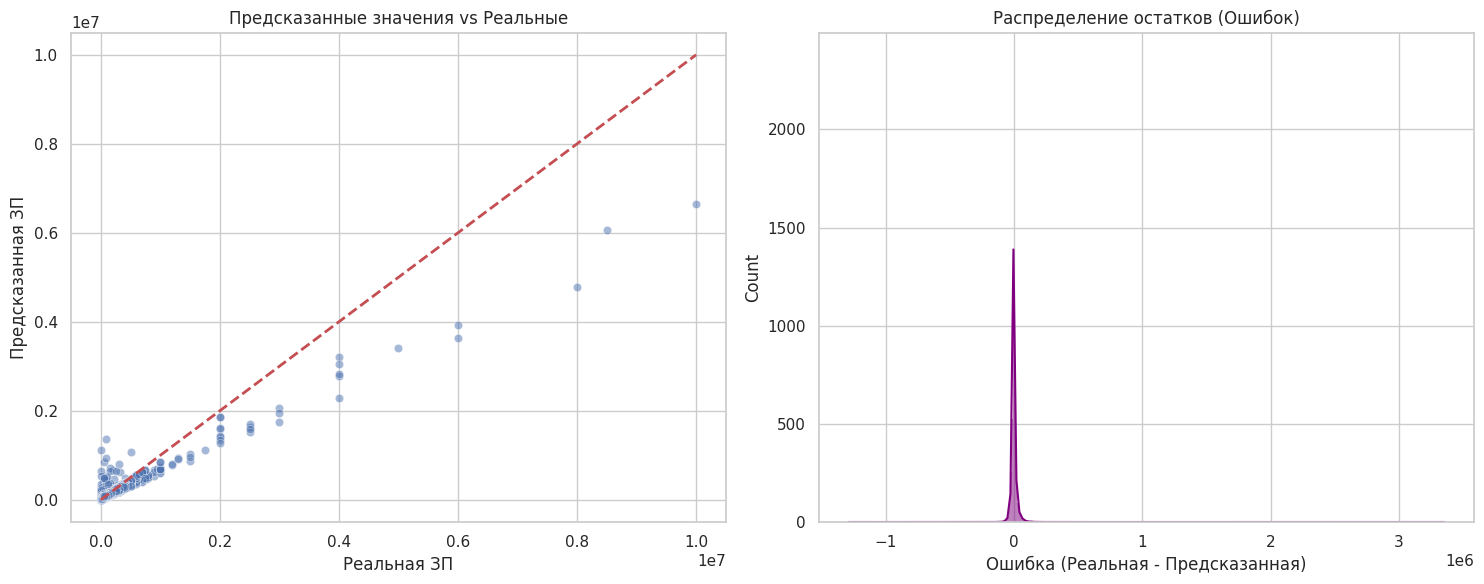

INFO: Средняя абсолютная ошибка (MAE): 12761.18 руб.
INFO: Коэффициент детерминации (R2): 0.88


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score


def visualize_results(y_true: np.ndarray, y_pred: np.ndarray) -> None:
    """
    Визуализирует результаты предсказаний модели через графики рассеяния и остатков.

    Создает два графика:
    1. Scatter plot сравнения истинных и предсказанных значений.
    2. Гистограмма распределения остатков (ошибок предсказания).

    Аргументы:
        y_true (np.ndarray): Массив истинных значений целевой переменной.
        y_pred (np.ndarray): Массив предсказанных значений.

    Вернёт:
        None

    Исключения:
        ValueError: Если размеры массивов y_true и y_pred не совпадают.
    """
    if len(y_true) != len(y_pred):
        logger.error("Размеры истинных и предсказанных значений не совпадают.")
        raise ValueError("Массивы y_true и y_pred должны быть одной длины.")

    logger.info("Генерация графиков визуализации результатов...")

    sns.set_theme(style="whitegrid")

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5, ax=axes[0])

    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

    axes[0].set_title('Предсказанные значения vs Реальные')
    axes[0].set_xlabel('Реальная ЗП')
    axes[0].set_ylabel('Предсказанная ЗП')

    residuals = y_true - y_pred
    sns.histplot(residuals, kde=True, ax=axes[1], color='purple')
    axes[1].set_title('Распределение остатков (Ошибок)')
    axes[1].set_xlabel('Ошибка (Реальная - Предсказанная)')

    plt.tight_layout()
    plt.show()

predictions = model.predict(x_data)
visualize_results(y_data, predictions)

mae = mean_absolute_error(y_data, predictions)
r2 = r2_score(y_data, predictions)

logger.info(f"Средняя абсолютная ошибка (MAE): {mae:.2f} руб.")
logger.info(f"Коэффициент детерминации (R2): {r2:.2f}")

## Задача классификации

Парсинг файла перед решением задачи классификации сделалаю заново. Вдруг что-то побилось или перезаписалось

INFO: Запуск PoC классификации для файла: sample_data/hh.csv
INFO: Загрузка: sample_data/hh.csv
INFO: Исправление кодировки (Mojibake)...
INFO: Фильтрация IT-специалистов...
INFO: Осталось записей после фильтрации: 50025
INFO: Разметка уровней (Junior/Middle/Senior)...
INFO: Глубокое извлечение признаков (Опыт + ЗП)...
INFO: Обучение RandomForest на числовых признаках...
INFO: 
ОБНОВЛЕННЫЙ ОТЧЕТ (С ОПЫТОМ)
              precision    recall  f1-score   support

      Junior       0.35      0.59      0.44      1036
      Middle       0.90      0.84      0.87      7268
      Senior       0.90      0.81      0.85      1701

    accuracy                           0.81     10005
   macro avg       0.72      0.74      0.72     10005
weighted avg       0.85      0.81      0.82     10005

DEBUG: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG: findfont: score(FontEntry(fname='/usr/local/lib/python3.12/dist-packages/matplotlib/mpl-data/fon

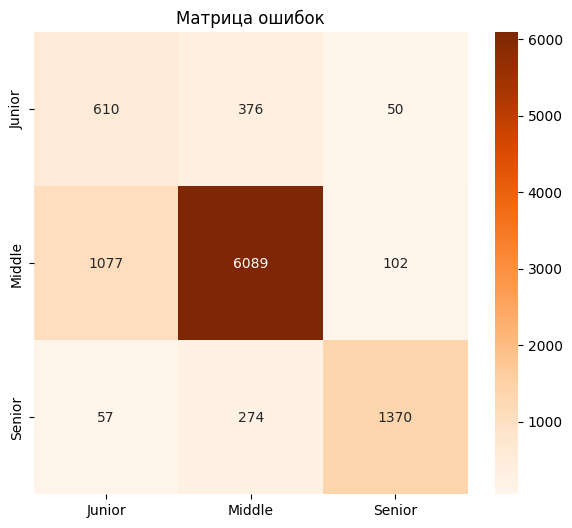

INFO: Классификация завершена успешно.


In [ ]:
import os
import re
import logging
from typing import Any, Optional

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Настройка логгера
logger = logging.getLogger(__name__)


class DevFilter(ProcessingStep):
    """
    Класс для фильтрации датасета.

    Оставляет только те записи, которые относятся к IT-разработке
    на основе анализа ключевых слов в тексте.
    """

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Фильтрует DataFrame, оставляя только IT-специалистов.

        Аргументы:
            df (pd.DataFrame): Исходный датасет.

        Вернет:
            pd.DataFrame: Отфильтрованный датасет.

        Исключения:
            Exception: Возникает при ошибке доступа к данным в столбцах.
        """
        logger.info("Фильтрация IT-специалистов...")

        keywords = [
            'разработчик', 'developer', 'programmer', 'программист',
            'frontend', 'backend', 'fullstack', 'python', 'java', 'c++', 'php'
        ]

        mask = df.apply(
            lambda x: x.astype(str).str.lower().str.contains(
                '|'.join(keywords)
            ).any(),
            axis=1
        )

        df_dev = df[mask].copy()
        logger.info(f"Осталось записей после фильтрации: {len(df_dev)}")
        return super().process(df_dev)


class LevelLabeler(ProcessingStep):
    """
    Класс для разметки целевой переменной.

    Определяет уровень специалиста (Junior, Middle, Senior) на основе
    текста резюме и опыта работы.
    """

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Проводит разметку уровней для каждой строки датасета.

        Аргументы:
            df (pd.DataFrame): Датасет разработчиков.

        Вернет:
            pd.DataFrame: Датасет с добавленным столбцом 'target_level'.

        Исключения:
            KeyError: Если в данных отсутствуют необходимые для анализа поля.
        """
        logger.info("Разметка уровней (Junior/Middle/Senior)...")

        def get_level(row: pd.Series) -> str:
            """
            Внутренняя логика определения уровня.

            Аргументы:
                row (pd.Series): Строка датасета.

            Вернет:
                str: Метка уровня.
            """
            text = " ".join(row.astype(str)).lower()

            senior_keys = [
                'senior', 'саньор', 'сеньор', 'ведущий', 'lead', 'лид',
                'architect'
            ]
            junior_keys = [
                'junior', 'джуниор', 'младший', 'intern', 'стажер', 'trainee'
            ]

            if any(x in text for x in senior_keys):
                return 'Senior'
            if any(x in text for x in junior_keys):
                return 'Junior'
            if any(x in text for x in ['middle', 'мидл']):
                return 'Middle'

            exp_col = next(
                (col for col in df.columns if 'опыт' in col.lower()),
                None
            )

            if exp_col:
                exp_str = str(row[exp_col])
                if 'без опыта' in exp_str.lower():
                    return 'Junior'

            return 'Middle'

        df['target_level'] = df.apply(get_level, axis=1)
        df = df[df['target_level'].isin(['Junior', 'Middle', 'Senior'])]

        return super().process(df)


class ClassificationFeatureEncoder(ProcessingStep):
    """
    Класс для подготовки признаков.
    Извлекает числовой опыт работы и зарплату.
    """

    def _extract_experience_months(self, text: str) -> int:
        """
        Вспомогательный метод для перевода строки опыта в число месяцев.

        Аргументы:
            text (str): Текстовое описание опыта (например, '2 года 3 месяца').

        Вернет:
            int: Суммарное количество месяцев опыта.

        Исключения:
            None: В случае ошибки парсинга или некорректного типа возвращает 0.
        """
        if not isinstance(text, str):
            return 0

        years = re.findall(r'(\d+)\s*(?:год|лет|г\.)', text.lower())
        months = re.findall(r'(\d+)\s*(?:месяц|мес\.)', text.lower())

        total_months = (sum(int(y) * 12 for y in years) +
                        sum(int(m) for m in months))
        return total_months

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Трансформирует текстовые признаки в числовой формат.

        Аргументы:
            df (pd.DataFrame): Датасет с размеченными уровнями.

        Вернет:
            pd.DataFrame: Датасет с числовыми признаками.

        Исключения:
            ValueError: При ошибке преобразования типов данных.
        """
        logger.info("Глубокое извлечение признаков (Опыт + ЗП)...")

        exp_col = next(
            (col for col in df.columns if 'опыт' in col.lower()),
            None
        )
        if exp_col:
            df['experience_months'] = df[exp_col].astype(str).apply(
                self._extract_experience_months
            )
            df.loc[
                df[exp_col].astype(str).str.contains(
                    'без опыта', case=False
                ), 'experience_months'
            ] = 0
            df = df.drop(columns=[exp_col])
        else:
            df['experience_months'] = 0

        target_col = next(
            (col for col in df.columns if 'ЗП' in col.upper()),
            None
        )
        if target_col:
            raw_salary = df[target_col].astype(str).str.replace(
                r'[^\d]', '', regex=True
            )
            df['salary_feature'] = pd.to_numeric(
                raw_salary, errors='coerce'
            ).fillna(0).astype(float)
            df = df.drop(columns=[target_col])
        else:
            df['salary_feature'] = 0.0

        features_to_encode = [c for c in df.columns if c != 'target_level']
        for col in features_to_encode:
            if df[col].dtype == 'object':
                le = LabelEncoder()
                df[col] = le.fit_transform(df[col].astype(str))

        return super().process(df)


class ClassificationTrainer(ProcessingStep):
    """
    Класс для обучения модели с весами, оптимизированными под числовые признаки.
    """

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Обучает модель с приоритетом на редкие классы (Junior).

        Аргументы:
            df (pd.DataFrame): Подготовленный датасет с признаками.

        Вернет:
            pd.DataFrame: Исходный датасет.

        Исключения:
            RuntimeError: При критической ошибке обучения.
        """
        logger.info("Обучение RandomForest на числовых признаках...")

        X = df.drop(columns=['target_level'])
        y = df['target_level']

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        custom_weights = {
            'Junior': 12.0,
            'Middle': 1.0,
            'Senior': 4.0
        }

        clf = RandomForestClassifier(
            n_estimators=300,
            max_depth=15,
            min_samples_leaf=2,
            class_weight=custom_weights,
            random_state=42,
            n_jobs=-1
        )

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        report = classification_report(y_test, y_pred)
        msg = (
            f"\n{'='*40}\nОБНОВЛЕННЫЙ ОТЧЕТ (С ОПЫТОМ)\n"
            f"{'='*40}\n{report}\n{'='*40}"
        )
        logger.info(msg)

        plt.figure(figsize=(7, 6))
        sns.heatmap(
            confusion_matrix(y_test, y_pred),
            annot=True,
            fmt='d',
            cmap='Oranges',
            xticklabels=clf.classes_,
            yticklabels=clf.classes_
        )
        plt.title('Матрица ошибок')
        plt.show()

        return df


def run_classification_app(csv_path: str) -> None:
    """
    Запускает конвейер классификации уровней IT-специалистов.

    Аргументы:
        csv_path (str): Путь к файлу с данными.

    Вернет:
        None

    Исключения:
        FileNotFoundError: Если файл не найден.
        Exception: Ошибки при выполнении конвейера.
    """
    logger.info(f"Запуск PoC классификации для файла: {csv_path}")

    pipeline = FileLoader()
    (pipeline.set_next(MojibakeCorrector())
             .set_next(DevFilter())
             .set_next(LevelLabeler())
             .set_next(ClassificationFeatureEncoder())
             .set_next(ClassificationTrainer()))

    try:
        pipeline.process(csv_path)
        logger.info("Классификация завершена успешно.")
    except Exception as e:
        logger.error(f"Критическая ошибка пайплайна: {e}")

run_classification_app(path_csv)

Для Junior специалистов получился самый низкий recall.
<br><br>
Показатели для остальных двух классов остаются очень высокими: 0.9 precision - это круто.